In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from scipy.optimize import minimize
# https://en.wikipedia.org/wiki/Efficient_frontier

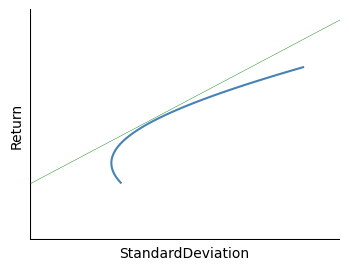

In [2]:

# Define returns, volatilities, and correlation
returns_portfolio1 = 0.10
volatility_portfolio1 = 0.15
returns_portfolio2 = 0.12
volatility_portfolio2 = 0.20 
correlation = 0.6

# Calculate the covariance between the two portfolios
covariance = correlation * volatility_portfolio1 * volatility_portfolio2

# Create the combined portfolio weights
weights = np.linspace(0, 1, 100)
combined_returns = weights * returns_portfolio1 + (1 - weights) * returns_portfolio2
combined_volatilities = np.sqrt((weights**2 * volatility_portfolio1**2) + 
                                ((1 - weights)**2 * volatility_portfolio2**2) + 
                                (2 * weights * (1 - weights) * covariance))

# Plot the two portfolios
plt.figure(figsize=(4, 3))
# plt.scatter(volatility_portfolio1, returns_portfolio1, color='red', label='Portfolio 1')
# plt.scatter(volatility_portfolio2, returns_portfolio2, color='blue', label='Portfolio 2')

# Plot the line that connects them
plt.plot(combined_volatilities, combined_returns, color='steelblue')

# Label the axes and add a legend
plt.xlabel('StandardDeviation')
plt.ylabel('Return')



x_left = 0.125
x_right = 0.21
y_bottom = 0.09
plt.ylim(bottom=y_bottom, top = 0.13)
plt.xlim(left=x_left,right=x_right)
# plt.legend()
plt.grid(False)
# plt.axhline(y=y_bottom, color='k', linewidth=1)  # x軸
# plt.axvline(x=x_left, color='k', linewidth=0.3)  # y軸
plt.axhline(y=y_bottom, color='k')  # x軸
plt.axvline(x=x_left, color='k')  # y軸
plt.xticks([])
plt.yticks([])

# Removing the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
x = np.linspace(0, 100)
y =  0.334*x + 0.058
plt.plot(x, y, 'g', linewidth=0.3)

# Show the plot
plt.show()


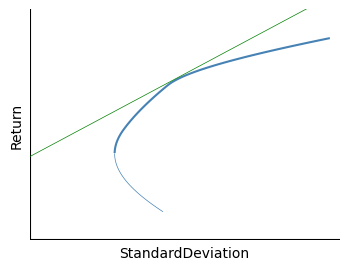

In [3]:
# Covariance matrix of the returns (for example purposes, we create a random positive semi-definite matrix)
np.random.seed(42)
A = np.random.rand(4,4)
cov_matrix = np.dot(A, A.transpose())



expected_returns = np.array([0.12, 0.10, 0.08, 0.06])  # for example purposes

# Function to calculate portfolio return
def calc_portfolio_return(weights, returns):
    return np.sum(weights * returns)

# Function to calculate portfolio volatility
def calc_portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to minimize (negative Sharpe Ratio)
def min_sharpe(weights, returns, cov_matrix, risk_free_rate=0):
    p_return = calc_portfolio_return(weights, returns)
    p_volatility = calc_portfolio_volatility(weights, cov_matrix)
    return -(p_return - risk_free_rate) / p_volatility

# Set the initial guess for the weights (equal distribution)
initial_guess = np.ones(len(expected_returns)) / len(expected_returns)

# Define the bounds for the weights (between 0 and 1)
bounds = tuple((0, 1) for _ in expected_returns)

# Define the constraints (weights sum to 1)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Create lists to store results
portfolio_returns = []
portfolio_volatilities = []
portfolio_weights = []

# Calculate efficient frontier
for return_target in np.linspace(min(expected_returns), max(expected_returns), 100):
    # Constraint for target return
    constraints_target = ({'type': 'eq', 'fun': lambda weights: calc_portfolio_return(weights, expected_returns) - return_target},
                          {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    # Optimize portfolio for maximum Sharpe ratio given return target
    result = minimize(min_sharpe, initial_guess, args=(expected_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints_target)
    
    # Store results
    if result.success:
        weights = result.x
        portfolio_weights.append(weights)
        portfolio_returns.append(return_target)
        portfolio_volatilities.append(calc_portfolio_volatility(weights, cov_matrix))

portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)

# Calculate the slope of the efficient frontier
slopes = np.diff(portfolio_returns) / np.diff(portfolio_volatilities)

# Identify the maximum return point where the slope starts to decrease (concave part)
max_slope_idx = np.argmax(slopes)


inefficient_returns = portfolio_returns[:max_slope_idx+1]
inefficient_volatilities = portfolio_volatilities[:max_slope_idx+1]
efficient_returns = portfolio_returns[max_slope_idx+1:]
efficient_volatilities = portfolio_volatilities[max_slope_idx+1:]


plt.figure(figsize=(4, 3))
plt.plot(efficient_volatilities, efficient_returns, 'steelblue', label='Efficient Frontier')
plt.plot(inefficient_volatilities, inefficient_returns, 'steelblue', linewidth=0.5, label='Inefficient Part of Frontier')
plt.xlabel('StandardDeviation')
plt.ylabel('Return')

x_bottom = 0.5
y_bottom = 0.05
plt.ylim(bottom=y_bottom, top = 0.13)
plt.xlim(left=x_bottom)
# plt.legend()
plt.grid(False)
plt.axhline(y=y_bottom, color='k')  # x軸
plt.axvline(x=x_bottom, color='k')  # y軸
plt.xticks([])
plt.yticks([])

# Removing the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
x = np.linspace(x_bottom, max(portfolio_volatilities), 100)
y = 0.062 * x + 0.048
plt.plot(x, y, 'g', linewidth=0.5)



plt.show()

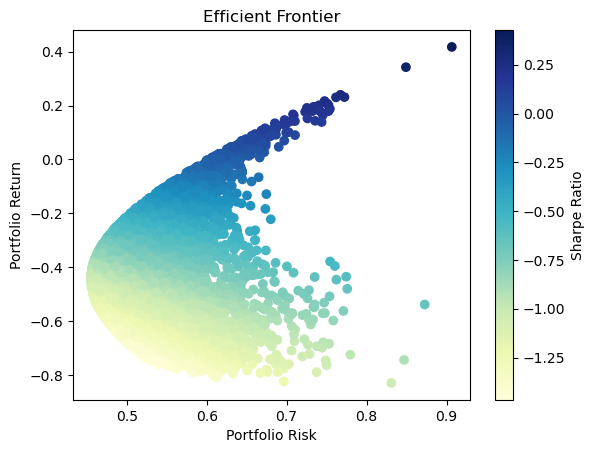

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Generating random data for demonstration purposes
np.random.seed(42)
num_assets = 4
num_portfolios = 10000
risk_free_rate = 0.03  # Risk-free rate of return

# Simulate random returns for 4 assets
returns = np.random.rand(num_assets, 252) * 0.2 - 0.1  # 252 trading days

# Calculate mean returns and covariance of returns of the assets
mean_returns = returns.mean(axis=1)
cov_matrix = np.cov(returns)

# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
    return portfolio_std, portfolio_return, sharpe_ratio

# Function to minimize (for the Sharpe ratio)
def minimize_volatility(weights, mean_returns, cov_matrix, risk_free_rate):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

# Generate portfolios
results = np.zeros((3, num_portfolios))
weights_record = []
for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_std, portfolio_return, sharpe_ratio = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
    results[0,i] = portfolio_std
    results[1,i] = portfolio_return
    results[2,i] = sharpe_ratio
    
# Plotting the efficient frontier
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()
